**---------------------Parsing file start from Here:-----------------**

In [1]:
file_name = '/home/azureuser/cloudfiles/code/Users/ujjwalpawar3004/container_testcase/input'

In [2]:
import os
my_folder_path = '/home/azureuser/cloudfiles/code/Users/ujjwalpawar3004/container_testcase/'
os.chdir(my_folder_path)

parsed_file_name = my_folder_path.replace('/home/azureuser/cloudfiles/code/Users/ujjwalpawar3004/', '').replace('/', '_').replace(' ', '_')
parsed_file_name

'container_testcase_'

In [3]:
import os
import pandas as pd
import json
import pprint
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import datetime
import os
import math

df=pd.DataFrame()


s=set()
f=open(file_name)
for i in f:
    t=json.loads(i)
    try:
        s.add(t['stream_context_info']['hook_name']+" : "+ t['stream_context_info']['codeletSetId'])
        # if(t['stream_context_info']['hook_name']=='midhaul_rx'):
        #     pprint.pprint(t)
    except KeyError:
        pass
f.close()

Hook_Vs_Codelet = {}
for entry in s:
    key, value = entry.split(" : ")
    Hook_Vs_Codelet[key.strip()] = value.strip()

print ("Number of hooks:",len(Hook_Vs_Codelet))
Hook_Vs_Codelet

Number of hooks: 16


{'mac_sinr_update': 'sinr_stats',
 'mac_ul_crc_ind': 'crc_stats',
 'mac_dl_harq': 'harq_dl_stats',
 'rlc_f1u_size': 'urf_ps',
 'midhaul_tx': 'mhtx_ps',
 'backhaul_tx': 'bhtx_ps',
 'rlc_mac_size': 'drm_ps',
 'f1u_rlc_size': 'dfr_ps',
 'mac_bsr_update': 'bsr_stats',
 'fapi_gnb_ul_config_req': 'fapi_gnb_ul_config_stats',
 'fapi_gnb_dl_config_req': 'fapi_gnb_dl_config_stats',
 'mac_rlc_size': 'umr_ps',
 'backhaul_rx': 'bhrx_ps',
 'mac_dl_bo_update': 'bo_stats',
 'mac_csi_report': 'csi_stats',
 'midhaul_rx': 'mhrx_ps'}

**Load the class:**

In [4]:
# class to parse the data from the file


def get_variance(value, bin, mean):
    var = []
    for i in range(len(value)):
        var.append(((value[i] - mean)**2)*bin[i])
    return sum(var)/sum(bin) if sum(bin) != 0 else 0

# Function to calculate skewness
def get_skewness(data):
    return float(np.mean((data - np.mean(data))**3) / (np.std(data)**3))

# Function to calculate kurtosis
def get_kurtosis(data):
    return float(np.mean((data - np.mean(data))**4) / (np.std(data)**4))
def get_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return iqr
def detect_outliers_mean_std(data, mean, std, num_std=2):
    lower_bound = mean - num_std * std
    upper_bound = mean + num_std * std
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return np.mean(outliers)

class parser:
    hist_shift ={'bhrx_ps' : 8 ,
                'bhtx_ps' : 8,
                'mhrx_ps' : 8,
                'mhtx_ps' : 8,
                'f1u_rlc_size' : 8,
                'fapi_gnb_dl_config_req_prb' : 5,
                'fapi_gnb_dl_config_req_mcs' : 2,
                'fapi_gnb_dl_config_req_tbs' : 13,
                'fapi_gnb_ul_config_req_prb' : 5,
                'fapi_gnb_ul_config_req_mcs' : 2,
                'fapi_gnb_ul_config_req_tbs' : 13,
                'mac_bsr_update' : 14,
                'mac_csi_report' : 2,
                'mac_dl_bo_update' : 8,
                'mac_dl_harq' : 0,
                'mac_rlc_size' : 8,
                'mac_sinr_update' : 5,
                'mac_ul_crc_ind' : 0,
                'rlc_f1u_size' : 8,
                'rlc_mac_size' : 8}
    def __init__(self, filename, timestamp):
        self.filename = filename
        self.timestamp = timestamp
        self.fig, self.axes = plt.subplots(nrows=3, ncols=3)
    # helper fucntions
    # get count given the key for histogram
    def cnt_calculator(self,inpt, key, valu, cnt_key):
        cnt=0
        for j in inpt:
            cnt+=j[cnt_key]
        return cnt
    # get avergae given the for histogram
    def calc_avg(self, bin,shift, min, max):
        total = 0
        BUCKET = 2**shift
        hist_value = [0] * 9
        cnt = 0
        for i, bin_count in enumerate(bin):
            if bin_count > 0:
                cnt+=1
                if(BUCKET*i<=min):
                    range_start = min
                else:
                    range_start = BUCKET*i
                if(BUCKET*(i + 1) - 1> max):
                    range_end = max
                else:
                    range_end = BUCKET*(i + 1) - 1
                range_size = range_end - range_start + 1
                items_per_bin = bin_count / range_size
                # Calculate total for this bin using formulas
                total += ((range_start + range_end) * range_size / 2)*items_per_bin
                # hist_value[i] = total
                # total=0
        return total/sum(bin)
    # get creates the histogram in array format
    def avg_packet_calc_hist(self, inpt, key, shift, min, max):
        hist = [0]*9
        for i in inpt:
            hist[i[key]]+=i['cnt']
        return self.calc_avg(hist,shift,min,max)
    # gets minimum value from the histogram
    def get_min(self, data):
        min_val = 99999999
        for i in data:
            if(i['val']<min_val):
                min_val = i['val']
        return min_val

    # gets maximum value from the histogram
    def get_max(self,data):
        max_val = 0
        for i in data:
            if(i['val']>max_val):
                max_val = i['val']
        return max_val
    # plot the histogram
    def show_plot(self):
        self.fig
    # calculate the runtime for platfrom kpi histogram
    def calc_runtime(self, bin):
        total = 0
        for i, bin_count in enumerate(bin):
            if bin_count > 0:
                range_start = 2 ** i
                range_end = 2 ** (i + 1) - 1
                range_size = range_end - range_start + 1
                items_per_bin = bin_count / range_size
                # Calculate total for this bin using formulas
                total += items_per_bin * ((range_start + range_end) * range_size/2)

        return total

    # calculate the hist stats for platfrom kpi histogram
    def calc_platform_hist(self, bin):
        total = 0
        value = []
        for i, bin_count in enumerate(bin):
            # print ("i, bin_count, bin:",i, bin_count, bin)
            if bin_count > 0:
                range_start = 2 ** i
                range_end = 2 ** (i + 1) - 1
                range_size = range_end - range_start + 1
                items_per_bin = bin_count / range_size
                # Calculate total for this bin using formulas
                value = np.append(value,((range_start + range_end) * range_size/2)*items_per_bin)
                total += items_per_bin * ((range_start + range_end) * range_size/2)


        mean = sum(value)/ sum(bin) if sum(bin) != 0 else 0
        var  = get_variance(value, bin, mean)
        std = var**0.5
        skewness = get_skewness(bin)
        kurtosis = get_kurtosis(bin)
        irq = get_iqr(bin)
        outliers = detect_outliers_mean_std(value, mean, std)
        return mean, var ,std, skewness, kurtosis, irq,  outliers

    # helper fuction calculate the hist stats for ran kpi histogram
    def get_procesesd_histogram(self, bin,shift, min, max):
        total = 0
        BUCKET = 2**shift
        hist_value = [0] * 9
        if len(bin) > 9:
          hist_value = [0] * len(bin)
        cnt = 0
        value = []
        # print ('bin:',bin)
        for i, bin_count in enumerate(bin):

            if bin_count > 0:
                cnt+=1
                if(BUCKET*i<=min):
                    range_start = min
                else:
                    range_start = BUCKET*i
                if(BUCKET*(i + 1) - 1> max):
                    range_end = max
                else:
                    range_end = BUCKET*(i + 1) - 1
                range_size = range_end - range_start + 1
                # print ('range_size, range_end,  range_start:',range_size, range_end,  range_start)
                items_per_bin = bin_count / range_size
                # Calculate total for this bin using formulas
                value = np.append(value,(((range_start + range_end) * range_size / 2)*items_per_bin))
                total += ((range_start + range_end) * range_size / 2)*items_per_bin
                # hist_value[i] = total
                # total=0
            else:
                value = np.append(value,0)
        # print ('value:', value)
        mean = sum(value)/ sum(bin)
        var  = get_variance(value, bin, mean)
        std = var**0.5
        skewness = get_skewness(bin)
        kurtosis = get_kurtosis(bin)
        irq = get_iqr(bin)
        outliers = detect_outliers_mean_std(value, mean, std)
        return mean, var ,std, skewness, kurtosis, irq,  outliers


    # fuction calculate the hist stats for ran kpi histogram
    def process_packet_hist(self, inpt, key, shift, min, max_in):
        hist = [0]*9

        # BO DL case
        max_key_value = max(inpt, key=lambda x: x[key])[key]
        if max_key_value + 1 > 9:
          hist = [0] * (max_key_value + 1)

        # print ('max_key_value:',max_key_value)
        for i in inpt:
            # print ("inpt, key, len(hist):",inpt, key, len(hist))
            # print(i[key])
            hist[i[key]]+=i['cnt']

        return self.get_procesesd_histogram(hist,shift,min,max_in)



    # fuctions to parse the hooks

    # parse f1u rlc size { kpi extracted : timestamp, cellId, stream_sn, stream_sn2, size, min, max, mean, range, std_dev, Interquartile range, Variance, skewness, kurtosis, outliers}
    def parse_f1u_rlc_size(self):
        self.axes[0,0].set_title('f1u_rlc_size : dfr_agg')
        df=pd.DataFrame()
        f=open(self.filename,'r')
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='f1u_rlc_size'):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    # pprint.pprint(tmp)
                    batch=tmp['batch']
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    k=0
                    holder['f1u_rlc_size']=0
                    for k in range(len(batch)):
                        holder['f1u_rlc_size']+=batch[k]['size']
                    holder['stream_sn']=t['stream_sn']
                    holder['stream_sn2']=t['stream_sn2']
                    holder['anomaly']=0
           #=============hisotgram calc==============================
                    max = self.get_max(tmp['packetSizeMax'])
                    min = self.get_min(tmp['packetSizeMin'])
                    min_max_range = max - min
                    hist__values = tmp['packetSizeHist']
                    hist__key = 'packetSize'
                    hist__shift = self.hist_shift['f1u_rlc_size']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['f1u_rlc_size_max'] = max
                    holder['f1u_rlc_size_min'] = min
                    holder['f1u_rlc_size_range'] = min_max_range
                    holder['f1u_rlc_size_mean'] = mean
                    holder['f1u_rlc_size_var'] = var
                    holder['f1u_rlc_size_std'] = std
                    holder['f1u_rlc_size_skewness'] = skewness
                    holder['f1u_rlc_size_kurtosis'] = kurtosis
                    holder['f1u_rlc_size_irq'] = irq
                    holder['f1u_rlc_size_outliers'] = outliers
						# =================================================
                    data.append(holder)
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['f1u_rlc_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[0,1])
        return df

    # parse mac dl bo update
    def parse_mac_dl_bo_update(self):
        self.axes[0,0].set_title('mac_dl_bo_update')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='mac_dl_bo_update'):
                    tmp= json.loads(t['stream_payload_msg'])
                    # pprint.pprint(tmp)
                    # break;
                    holder={}
                    # batch=tmp['batch']
                    k=0
                    holder['cellId']=tmp['cellId']
                    holder['timestamp']=tmp['timestamp']
                    # holder['Mac_dl_bo_size']=0
                    # for k in range(len(batch)):
                    #     holder['Mac_dl_bo_size']+=batch[k]['size']
                    holder['stream_sn']=t['stream_sn']
              #=============hisotgram calc==============================
                    max = self.get_max(tmp['l2BoMax'])
                    min = self.get_min(tmp['l2BoMin'])
                    min_max_range = max - min
                    hist__values = tmp['l2BoHist']
                    hist__key = 'queueLoad'
                    hist__shift = self.hist_shift['mac_dl_bo_update']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['mac_dl_bo_max'] = max
                    holder['mac_dl_bo_min'] = min
                    holder['mac_dl_bo_range'] = min_max_range
                    holder['mac_dl_bo_mean'] = mean
                    holder['mac_dl_bo_var'] = var
                    holder['mac_dl_bo_std'] = std
                    holder['mac_dl_bo_skewness'] = skewness
                    holder['mac_dl_bo_kurtosis'] = kurtosis
                    holder['mac_dl_bo_irq'] = irq
                    holder['mac_dl_bo_outliers'] = outliers
						# =================================================

                    # holder['MAC_DL_BO_MAX'] = self.get_max(tmp['l2BoMax'])
                    # holder['MAC_DL_BO_MIN'] = self.get_max(tmp['l2BoMin'])
                    holder['stream_sn2']=t['stream_sn2']
                    holder['anomaly']=0
                    data.append(holder)
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        # t=df['size']
        # t=t/(1024*128)
        # t.plot(ax=self.axes[0,1])
        return df

    #parse mac rlc size
    def parse_mac_rlc_size(self):
        self.axes[0,2].set_title('mac_rlc_size')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='mac_rlc_size'):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    batch=tmp['batch']
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    k=0
                    holder['mac_rlc_size']=0
                    for k in range(len(batch)):
                        holder['mac_rlc_size']+=batch[k]['size']
                    holder['stream_sn']=t['stream_sn']
                    holder['stream_sn2']=t['stream_sn2']
                    holder['anomaly']=0
              #=============hisotgram calc==============================
                    max = self.get_max(tmp['packetSizeMax'])
                    min = self.get_min(tmp['packetSizeMin'])
                    min_max_range = max - min
                    hist__values = tmp['packetSizeHist']
                    hist__key = 'packetSize'
                    hist__shift = self.hist_shift['f1u_rlc_size']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['mac_rlc_size_max'] = max
                    holder['mac_rlc_size_min'] = min
                    holder['mac_rlc_size_range'] = min_max_range
                    holder['mac_rlc_size_mean'] = mean
                    holder['mac_rlc_size_var'] = var
                    holder['mac_rlc_size_std'] = std
                    holder['mac_rlc_size_skewness'] = skewness
                    holder['mac_rlc_size_kurtosis'] = kurtosis
                    holder['mac_rlc_size_irq'] = irq
                    holder['mac_rlc_size_outliers'] = outliers
						# =================================================

                    data.append(holder)
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['mac_rlc_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[0,2])
        return df

    # parse rlc f1u size
    def parse_rlc_f1u_size(self):
        self.axes[1,0].set_title('rlc_f1u_size')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='rlc_f1u_size'):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    batch=tmp['batch']
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    k=0
                    holder['rlc_f1u_size']=0
                    for k in range(len(batch)):
                        holder['rlc_f1u_size']+=batch[k]['size']
                    holder['anomaly']=0
                    holder['stream_sn']=t['stream_sn']
                    holder['stream_sn2']=t['stream_sn2']
            #=============hisotgram calc==============================
                    max = self.get_max(tmp['packetSizeMax'])
                    min = self.get_min(tmp['packetSizeMin'])
                    min_max_range = max - min
                    hist__values = tmp['packetSizeHist']
                    hist__key = 'packetSize'
                    hist__shift = self.hist_shift['rlc_f1u_size']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['rlc_f1u_size_max'] = max
                    holder['rlc_f1u_size_min'] = min
                    holder['rlc_f1u_size_range'] = min_max_range
                    holder['rlc_f1u_size_mean'] = mean
                    holder['rlc_f1u_size_var'] = var
                    holder['rlc_f1u_size_std'] = std
                    holder['rlc_f1u_size_skewness'] = skewness
                    holder['rlc_f1u_size_kurtosis'] = kurtosis
                    holder['rlc_f1u_size_irq'] = irq
                    holder['rlc_f1u_size_outliers'] = outliers
						# =================================================



                    data.append(holder)
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['rlc_f1u_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[1,0])
        return df

    #parse rlc mac size
    def parse_rlc_mac_size(self):
        self.axes[1,1].set_title('rlc_mac_size')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='rlc_mac_size'):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    batch=tmp['batch']
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    k=0
                    holder['rlc_mac_size']=0
                    for k in range(len(batch)):
                        holder['rlc_mac_size']+=batch[k]['size']
                    holder['stream_sn']=t['stream_sn']
                    holder['stream_sn2']=t['stream_sn2']
                    holder['anomaly']=0
            #=============hisotgram calc==============================
                    max = self.get_max(tmp['packetSizeMax'])
                    min = self.get_min(tmp['packetSizeMin'])
                    min_max_range = max - min
                    hist__values = tmp['packetSizeHist']
                    hist__key = 'packetSize'
                    hist__shift = self.hist_shift['rlc_mac_size']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['rlc_mac_size_max'] = max
                    holder['rlc_mac_size_min'] = min
                    holder['rlc_mac_size_range'] = min_max_range
                    holder['rlc_mac_size_mean'] = mean
                    holder['rlc_mac_size_var'] = var
                    holder['rlc_mac_size_std'] = std
                    holder['rlc_mac_size_skewness'] = skewness
                    holder['rlc_mac_size_kurtosis'] = kurtosis
                    holder['rlc_mac_size_irq'] = irq
                    holder['rlc_mac_size_outliers'] = outliers
						# =================================================

                    data.append(holder)
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['rlc_mac_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[1,1])
        return df

    # parse mhtx
    def parse_mhtx(self):
        self.axes[1,2].set_title('mhtx_agg')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['codeletSetId']==Hook_Vs_Codelet['midhaul_tx']):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    if('batchOut' in tmp.keys()):
              #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxOut'])
                        min = self.get_min(tmp['packetSizeMinOut'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistOut']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['mhtx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['MHTX_Out_max'] = max
                        holder['MHTX_Out_min'] = min
                        holder['MHTX_Out_range'] = min_max_range
                        holder['MHTX_Out_mean'] = mean
                        holder['MHTX_Out_var'] = var
                        holder['MHTX_Out_std'] = std
                        holder['MHTX_Out_skewness'] = skewness
                        holder['MHTX_Out_kurtosis'] = kurtosis
                        holder['MHTX_Out_irq'] = irq
                        holder['MHTX_Out_outliers'] = outliers
						# =================================================

                        batch=tmp['batchOut']
                        k=0
                        holder['MHTX_Out_size']=0
                        for k in range(len(batch)):
                            holder['MHTX_Out_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)
                    else:
             #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxIn'])
                        min = self.get_min(tmp['packetSizeMinIn'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistIn']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['mhtx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['MHTX_In_max'] = max
                        holder['MHTX_In_min'] = min
                        holder['MHTX_In_range'] = min_max_range
                        holder['MHTX_In_mean'] = mean
                        holder['MHTX_In_var'] = var
                        holder['MHTX_In_std'] = std
                        holder['MHTX_In_skewness'] = skewness
                        holder['MHTX_In_kurtosis'] = kurtosis
                        holder['MHTX_In_irq'] = irq
                        holder['MHTX_In_outliers'] = outliers
                        #============================================================

                        batch=tmp['batchIn']
                        k=0
                        holder['MHTX_In_size']=0
                        for k in range(len(batch)):
                            holder['MHTX_In_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)
            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['MHTX_Out_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[1,2])
        t=df['MHTX_In_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[1,2])
        return df

    # parse bhtx
    def parse_bhtx(self):
        self.axes[2,0].set_title('bhtx_ps')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['codeletSetId']==Hook_Vs_Codelet['backhaul_tx']):
                    tmp= json.loads(t['stream_payload_msg'])
                    # pprint.pprint (tmp)
                    # break;
                    holder={}
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    # pprint.pprint (tmp)
                    if('batchOut' in tmp.keys()):
                    #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxOut'])
                        min = self.get_min(tmp['packetSizeMinOut'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistOut']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['bhtx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['BHTX_Out_max'] = max
                        holder['BHTX_Out_min'] = min
                        holder['BHTX_Out_range'] = min_max_range
                        holder['BHTX_Out_mean'] = mean
                        holder['BHTX_Out_var'] = var
                        holder['BHTX_Out_std'] = std
                        holder['BHTX_Out_skewness'] = skewness
                        holder['BHTX_Out_kurtosis'] = kurtosis
                        holder['BHTX_Out_irq'] = irq
                        holder['BHTX_Out_outliers'] = outliers
                        #============================================================

                        # pprint.pprint(tmp)
                        # break;
                        batch=tmp['batchOut']
                        # k=0
                        holder['BHTX_Out_size']=0
                        holder['BHTX_Out_size'] += sum(entry['size'] for entry in batch)
                        # for k in range(len(batch)):
                        #     holder['out_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)
                    else:
                        #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxIn'])
                        min = self.get_min(tmp['packetSizeMinIn'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistIn']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['bhtx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['BHTX_In_max'] = max
                        holder['BHTX_In_min'] = min
                        holder['BHTX_In_range'] = min_max_range
                        holder['BHTX_In_mean'] = mean
                        holder['BHTX_In_var'] = var
                        holder['BHTX_In_std'] = std
                        holder['BHTX_In_skewness'] = skewness
                        holder['BHTX_In_kurtosis'] = kurtosis
                        holder['BHTX_In_irq'] = irq
                        holder['BHTX_In_outliers'] = outliers
                        #============================================================
                        batch=tmp['batchIn']
                        # pprint.pprint(tmp)
                        # print("batch, len(batch):",batch, len(batch))
                        # k=0
                        holder['BHTX_In_size']=0
                        # print ("batch[0]['size']:",batch[0]['size'])
                        holder['BHTX_In_size'] += sum(entry['size'] for entry in batch)
                        # for k in range(len(batch)):
                        #     holder['in_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)

            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)

        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['BHTX_Out_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,0])
        t=df['BHTX_In_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,0])
        return df

    # parse bhrx
    def parse_bhrx(self):
        self.axes[2,1].set_title('bhrx_agg')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['codeletSetId']==Hook_Vs_Codelet['backhaul_rx']):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    if('batchOut' in tmp.keys()):
                    #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxOut'])
                        min = self.get_min(tmp['packetSizeMinOut'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistOut']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['bhrx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['BHRX_Out_max'] = max
                        holder['BHRX_Out_min'] = min
                        holder['BHRX_Out_range'] = min_max_range
                        holder['BHRX_Out_mean'] = mean
                        holder['BHRX_Out_var'] = var
                        holder['BHRX_Out_std'] = std
                        holder['BHRX_Out_skewness'] = skewness
                        holder['BHRX_Out_kurtosis'] = kurtosis
                        holder['BHRX_Out_irq'] = irq
                        holder['BHRX_Out_outliers'] = outliers
                        #================================================================
                        batch=tmp['batchOut']
                        k=0
                        holder['BHRX_Out_size']=0
                        for k in range(len(batch)):
                            holder['BHRX_Out_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)
                    else:
                        #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxIn'])
                        min = self.get_min(tmp['packetSizeMinIn'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistIn']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['bhrx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['BHRX_In_max'] = max
                        holder['BHRX_In_min'] = min
                        holder['BHRX_In_range'] = min_max_range
                        holder['BHRX_In_mean'] = mean
                        holder['BHRX_In_var'] = var
                        holder['BHRX_In_std'] = std
                        holder['BHRX_In_skewness'] = skewness
                        holder['BHRX_In_kurtosis'] = kurtosis
                        holder['BHRX_In_irq'] = irq
                        holder['BHRX_In_outliers'] = outliers
                        #============================================================

                        batch=tmp['batchIn']
                        k=0
                        holder['BHRX_In_size']=0
                        for k in range(len(batch)):
                            holder['BHRX_In_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)

            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['BHRX_Out_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,1])
        t=df['BHRX_In_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,1])
        return df

    # parse mhrx
    def parse_mhrx(self):
        self.axes[2,2].set_title('mhrx_agg')
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['codeletSetId']==Hook_Vs_Codelet['midhaul_rx']):
                    tmp= json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
                    holder['cellId']=tmp['cellId']
                    if('batchOut' in tmp.keys()):
                  #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxOut'])
                        min = self.get_min(tmp['packetSizeMinOut'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistOut']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['mhrx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['MHRX_Out_max'] = max
                        holder['MHRX_Out_min'] = min
                        holder['MHRX_Out_range'] = min_max_range
                        holder['MHRX_Out_mean'] = mean
                        holder['MHRX_Out_var'] = var
                        holder['MHRX_Out_std'] = std
                        holder['MHRX_Out_skewness'] = skewness
                        holder['MHRX_Out_kurtosis'] = kurtosis
                        holder['MHRX_Out_irq'] = irq
                        holder['MHRX_Out_outliers'] = outliers
						       # =================================================

                        batch=tmp['batchOut']
                        k=0
                        holder['MHRX_Out_size']=0
                        for k in range(len(batch)):
                            holder['MHRX_Out_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)
                    else:
                        #=============hisotgram calc==============================
                        max = self.get_max(tmp['packetSizeMaxIn'])
                        min = self.get_min(tmp['packetSizeMinIn'])
                        min_max_range = max - min
                        hist__values = tmp['packetSizeHistIn']
                        hist__key = 'packetSize'
                        hist__shift = self.hist_shift['mhrx_ps']
                        mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                        holder['MHRX_In_max'] = max
                        holder['MHRX_In_min'] = min
                        holder['MHRX_In_range'] = min_max_range
                        holder['MHRX_In_mean'] = mean
                        holder['MHRX_In_var'] = var
                        holder['MHRX_In_std'] = std
                        holder['MHRX_In_skewness'] = skewness
                        holder['MHRX_In_kurtosis'] = kurtosis
                        holder['MHRX_In_irq'] = irq
                        holder['MHRX_In_outliers'] = outliers
                        #============================================================

                        batch=tmp['batchIn']
                        k=0
                        holder['MHRX_In_size']=0
                        for k in range(len(batch)):
                            holder['MHRX_In_size']+=batch[k]['size']
                        holder['stream_sn']=t['stream_sn']
                        holder['stream_sn2']=t['stream_sn2']
                        holder['anomaly']=0
                        data.append(holder)

            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        t=df['MHRX_Out_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,2])
        t=df['MHRX_In_size']
        t=t/(1024*128)
        t.plot(ax=self.axes[2,2])
        return df


    # parse fapi dl config
    def parse_fapi_dl_config(self):
        df=pd.DataFrame()
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']=='fapi_gnb_dl_config_req'):
                    tmp=json.loads(t['stream_payload_msg'])
                    # pprint.pprint(tmp)
                    # break;
                    avg_l1_prbSize = self.avg_packet_calc_hist(tmp['l1DlcPrbHist'], 'prbSize', self.hist_shift['fapi_gnb_dl_config_req_prb'], self.get_min(tmp['l1PrbMin']), self.get_max(tmp['l1PrbMax']))
                    # print(avg_l1_prbSize)
                    avg_l1_mcs = self.avg_packet_calc_hist(tmp['l1DlcMcsHist'], 'mcs', self.hist_shift['fapi_gnb_dl_config_req_mcs'], self.get_min(tmp['l1McsMin']), self.get_max(tmp['l1McsMax']))
                    # print(avg_l1_mcs)
                    avg_l1_tbs = self.avg_packet_calc_hist(tmp['l1DlcTbsHist'], 'tbsSize', self.hist_shift['fapi_gnb_dl_config_req_tbs'], self.get_min(tmp['l1TbsMin']), self.get_max(tmp['l1TbsMax']))
                    # print(avg_l1_tbs)
                    pdsch_cnt = self.cnt_calculator(tmp['l1DlcTbsHist'], 'rnti', 'tbsSize', 'cnt')
                    # print(pdsch_cnt)
                    avg_pdsch = pdsch_cnt / len(tmp['l1DlcTbsHist'])

                    # avg_pdsch = np.mean(list(self.avg_packet_calc(tmp['l1DlcTbsHist'], 'rnti', 'tbsSize', 'cnt').values()))

                    # l1_tx = tmp['l1DlcTx'][0]['tx']
                    # sum traffic for all rnti
                    sum_tx = 0
                    for item in tmp['l1DlcTx']:
                        sum_tx += item['tx']
                    l1_tx = sum_tx

                    tdf=pd.DataFrame()
                    # print ('timestamp','avg_l1_prbSize', avg_l1_prbSize,'avg_l1_mcs', avg_l1_mcs,'avg_l1_tbs', avg_l1_tbs,'l1_tx', l1_tx,'l1McsMin', self.get_min(tmp['l1McsMin']),'l1McsMax', self.get_max(tmp['l1McsMax']),'l1TbsMax', self.get_max(tmp['l1TbsMax']),'l1TbsMin', self.get_min(tmp['l1TbsMin']),'l1PrbMax', self.get_max(tmp['l1PrbMax']),'l1PrbMin', self.get_min(tmp['l1PrbMin']),'pdsch_count':pdsch_cnt, 'avg_pdsch', avg_pdsch ,'anomaly', 0)
                    # tdf=pd.DataFrame({'timestamp': tmp['timestamp'],'avg_l1_prbSize': avg_l1_prbSize,'avg_l1_mcs': avg_l1_mcs,'avg_l1_tbs': avg_l1_tbs,'l1_tx': l1_tx },index=[0])
                    data.append({'timestamp': tmp['timestamp'],'l1_avg_prbSize': avg_l1_prbSize,'l1_avg_mcs': avg_l1_mcs,'l1_avg_tbs': avg_l1_tbs,'l1_tx': l1_tx,'l1_McsMin':self.get_min(tmp['l1McsMin']),'l1_McsMax':self.get_max(tmp['l1McsMax']),'l1_TbsMax':self.get_max(tmp['l1TbsMax']),'l1_TbsMin':self.get_min(tmp['l1TbsMin']),'l1_PrbMax':self.get_max(tmp['l1PrbMax']),'l1_PrbMin':self.get_min(tmp['l1PrbMin']),'l1_pdsch_count':pdsch_cnt, 'l1_avg_pdsch':avg_pdsch ,'anomaly':0})
            except KeyError:
                pass
        f.close()
        # pprint.pprint(data)
        df = pd.DataFrame.from_dict(data)

        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1

        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        return df

    # parse mac bsr update
    def parse_mac_bsr_update(self):
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'mac_bsr_update'):

                    tmp=json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
            #=============hisotgram calc==============================
                    max = self.get_max(tmp['l2BsrMax'])
                    min = self.get_min(tmp['l2BsrMin'])
                    min_max_range = max - min
                    hist__values = tmp['l2BsrHist']
                    hist__key = 'queueLoad'
                    hist__shift = self.hist_shift['mac_bsr_update']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['mac_bsr_update_max'] = max
                    holder['mac_bsr_update_min'] = min
                    holder['mac_bsr_update_range'] = min_max_range
                    holder['mac_bsr_update_mean'] = mean
                    holder['mac_bsr_update_var'] = var
                    holder['mac_bsr_update_std'] = std
                    holder['mac_bsr_update_skewness'] = skewness
                    holder['mac_bsr_update_kurtosis'] = kurtosis
                    holder['mac_bsr_update_irq'] = irq
                    holder['mac_bsr_update_outliers'] = outliers
                    holder['anomaly']=0
                    data.append(holder)
						# =================================================
                    # data.append(holder) #,'l2BsrMin':tmp['l2BsrMin'][0]['val']
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1

        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        return df

    # parse mac csi update
    def parse_mac_csi_report(self):
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'mac_csi_report'):
                    tmp=json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
                    # pprint.pprint(tmp)
                    # break;
            #=============hisotgram calc==============================
                    max = self.get_max(tmp['l2CsiMax'])
                    min = self.get_min(tmp['l2CsiMin'])
                    min_max_range = max - min
                    hist__values = tmp['l2CsiHist']
                    hist__key = 'val'
                    hist__shift = self.hist_shift['mac_csi_report']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['mac_csi_report_max'] = max
                    holder['mac_csi_report_min'] = min
                    holder['mac_csi_report_range'] = min_max_range
                    holder['mac_csi_report_mean'] = mean
                    holder['mac_csi_report_var'] = var
                    holder['mac_csi_report_std'] = std
                    holder['mac_csi_report_skewness'] = skewness
                    holder['mac_csi_report_kurtosis'] = kurtosis
                    holder['mac_csi_report_irq'] = irq
                    holder['mac_csi_report_outliers'] = outliers
                    holder['anomaly']=0
                    data.append(holder)
			# =================================================
                    # avg_l2_Csi = math.ceil(list(self.avg_calculator(tmp['l2CsiHist'], 'rnti', 'val', 'cnt').values())[0])
                    # data.append({'timestamp': tmp['timestamp'],'l2CsiMin':self.get_min(tmp['l2CsiMin']),'l2CsiMax':self.get_max(tmp['l2CsiMax']),'anomaly':0}) #,'l2CsiMin':tmp['l2CsiMin'][0]['val']

                    # break;
            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        return df

    # parse mac dl harq
    def parse_mac_dl_harq(self):
        data =[]
        f=open(self.filename)
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'mac_dl_harq'):
                    tmp=json.loads(t['stream_payload_msg'])
                    # pprint.pprint(tmp)
                    # break;
                    total = 0
                    nack = 0
                    ack = 0
                    for  i in tmp['l2HarqCnt']:
                        total+=i['cnt']
                        nack+=i['nack']
                        ack+=i['ack']
                    consMax = 0
                    for i in tmp['l2HarqConsMax']:
                        consMax = np.max(i['val'])
                    # tdf=pd.DataFrame({'timestamp': tmp['timestamp'],'avg_l2_Harq_ACK':avg_l2_Harq_ACK, 'avg_l2_Harq_NACK':avg_l2_Harq_NACK, 'avg_l2_Harq_DTX':avg_l2_Harq_DTX },index=[0])
                    data.append({'timestamp': tmp['timestamp'],'mac_dl_harq_total': total, 'mac_dl_harq_NACK': nack, 'mac_dl_harq_ACK': ack,'mac_dl_harq_max_cons_loss':consMax, 'mac_dl_harq_nack_rate' : (nack/total) , 'anomaly':0 }) # ,'l2HarqConsMax':tmp['l2HarqConsMax'][0]['val']

                    # break;
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        return df

    # parse mac sinr update
    def parse_mac_sinr_update(self):
        data =[]
        f=open(self.filename)
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'mac_sinr_update'):
                    tmp=json.loads(t['stream_payload_msg'])
                    holder={}
                    holder['timestamp']=tmp['timestamp']
            #=============hisotgram calc==============================
                    max = self.get_max(tmp['l2SinrMax'])
                    min = self.get_min(tmp['l2SinrMin'])
                    min_max_range = max - min
                    hist__values = tmp['l2SinrHist']
                    hist__key = 'val'
                    hist__shift = self.hist_shift['mac_sinr_update']
                    mean, var ,std, skewness, kurtosis, irq,  outliers = self.process_packet_hist(hist__values, hist__key, hist__shift, min, max)
                    holder['mac_sinr_update_max'] = max
                    holder['mac_sinr_update_min'] = min
                    holder['mac_sinr_update_range'] = min_max_range
                    holder['mac_sinr_update_mean'] = mean
                    holder['mac_sinr_update_var'] = var
                    holder['mac_sinr_update_std'] = std
                    holder['mac_sinr_update_skewness'] = skewness
                    holder['mac_sinr_update_kurtosis'] = kurtosis
                    holder['mac_sinr_update_irq'] = irq
                    holder['mac_sinr_update_outliers'] = outliers
                    holder['anomaly']=0
                    data.append(holder)
			# =================================================


                    # avg_l2_Sinr = math.ceil(list(self.avg_calculator(tmp['l2SinrHist'], 'rnti', 'val', 'cnt').values())[0])
                    # data.append({'timestamp': tmp['timestamp'],'l2SinrMax':self.get_max(tmp['l2SinrMax']),'l2SinrMin':self.get_min(tmp['l2SinrMin']), 'anomaly':0})
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        return df

    # parse mac ul crc ind
    def parse_mac_ul_crc_ind(self):
        data =[]
        f=open(self.filename)
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'mac_ul_crc_ind'):
                    tmp=json.loads(t['stream_payload_msg'])
                    # print (tmp)
                    # break;

                    # avg_l2_Crc = math.ceil(list(self.avg_calculator(tmp['l2CrcHist'], 'rnti', 'loss', 'cnt').values())[0])
                    loss = 0
                    total = 0
                    for i in tmp['l2Avg']:
                        loss+=i['loss']
                        total+=i['total']

                    data.append({'timestamp': tmp['timestamp'],'mac_ul_CRC_Max':self.get_max(tmp['l2Max']),'mac_ul_CRC_Min':self.get_min(tmp['l2Max']), 'mac_ul_CRC_Loss': loss,'mac_ul_CRC_Loss_Rate': loss/total, 'mac_ul_CRC_Total':total, 'anomaly': 0 }) # ,'l2CrcMax':tmp['l2CrcMax'][0]['val']

                    # break;
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        return df


    # parse fapi gnb ul config req
    def parse_fapi_gnb_ul_config_req(self):
        data = []
        f=open(self.filename)
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_context_info']['hook_name']== 'fapi_gnb_ul_config_req'):
                    tmp=json.loads(t['stream_payload_msg'])
                    # pprint.pprint(tmp)
                    # break;
                    # pucsh_count = 0
                    # for i in tmp['l1UlcTbsHist']:
                    #     pucsh_count+=i['cnt']
                    # avg_pusch = np.mean(list(self.avg_packet_calc(tmp['l1UlcPrbHist'], 'prbSize', 'tbsSize', 'cnt').values()))
                    # avg_l1_UL_prbSize = math.ceil(list(self.avg_calculator(tmp['l1UlcPrbHist'], 'rnti', 'prbSize', 'cnt').values())[0])
                    # avg_l1_UL_mcs = math.ceil(list(self.avg_calculator(tmp['l1UlcMcsHist'], 'rnti', 'mcs', 'cnt').values())[0])
                    # avg_l1_UL_tbs = math.ceil(list(self.avg_calculator(tmp['l1UlcTbsHist'], 'rnti', 'tbsSize', 'cnt').values())[0])

                    avg_l1_UL_prbSize = self.avg_packet_calc_hist(tmp['l1UlcPrbHist'], 'prbSize', self.hist_shift['fapi_gnb_ul_config_req_prb'], self.get_min(tmp['l1PrbMin']), self.get_max(tmp['l1PrbMax']))
                    avg_l1_UL_mcs = self.avg_packet_calc_hist(tmp['l1UlcMcsHist'], 'mcs', self.hist_shift['fapi_gnb_ul_config_req_mcs'], self.get_min(tmp['l1McsMin']), self.get_max(tmp['l1McsMax']))
                    avg_l1_UL_tbs = self.avg_packet_calc_hist(tmp['l1UlcTbsHist'], 'tbsSize', self.hist_shift['fapi_gnb_ul_config_req_tbs'], self.get_min(tmp['l1TbsMin']), self.get_max(tmp['l1TbsMax']))
                    pucsh_cnt = self.cnt_calculator(tmp['l1UlcTbsHist'], 'rnti', 'tbsSize', 'cnt')
                    avg_pusch = pucsh_cnt / len(tmp['l1UlcTbsHist'])


                    l1_UL_tx=0
                    for i in tmp['l1UlcTx']:
                        l1_UL_tx += i['tx']
                    # tdf=pd.DataFrame({'timestamp': tmp['timestamp'],'avg_l1_UL_prbSize': avg_l1_UL_prbSize,'avg_l1_UL_mcs': avg_l1_UL_mcs,'avg_l1_UL_tbs': avg_l1_UL_tbs,'l1_UL_tx': l1_UL_tx },index=[0])
                    data.append({'timestamp': tmp['timestamp'], 'l1_pusch_count': pucsh_cnt, 'l1_avg_pusch_count': avg_pusch ,'l1_avg_UL_prbSize': avg_l1_UL_prbSize,'l1_avg_UL_mcs': avg_l1_UL_mcs,'l1_avg_UL_tbs': avg_l1_UL_tbs,'l1_UL_tx': l1_UL_tx,'l1_ULMcsMin':self.get_min(tmp['l1McsMin']),'l1_ULMcsMax':self.get_min(tmp['l1McsMax']),'l1_ULTbsMax':self.get_min(tmp['l1TbsMax']),'l1_ULTbsMin':self.get_min(tmp['l1TbsMin']),'l1_ULPrbMax':self.get_max(tmp['l1PrbMax']),'l1_ULPrbMin':self.get_max(tmp['l1PrbMin']), 'anomaly':0  })

                    # break;
            except KeyError:
                pass
        f.close()
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = df['timestamp'].astype(np.int64)
        df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ns')
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        return df


    # parse platform kpi
    def parse_platform(self):
        f=open(self.filename)
        data =[]
        for i in f:
            t=json.loads(i)
            try:
                if(t['stream_type']=='ebpf' and t['host_name']=='telco-2'):
                    tmp = t['processes']
                    total_bin = [0]*16
                    max_runtime = 0
                    for i in tmp:
                      if(i['process_name'] != 'OS swapper'):
                        for j in i['threads']:
                            total_bin = [x + y for x, y in zip(total_bin, j['bins'])]
                            max_runtime = max(max_runtime,j['max'])
 
                    for i in tmp:
                        for j in i['threads']:
                            ## added after meeting with bozidar
                            if(i['process_name'] != 'OS swapper'):
                                holder = {}
                                holder['process_name'] = i['process_name']
                                holder['process_id'] = i['process_id']
                                holder['thread_id']=j['thread_id']
                                holder['thread_name']=j['thread_name']
                                holder['max']=j['max']
                                holder['total_events']=j['total']

                                holder['others_runtime_bin']= [a_i - b_i for a_i, b_i in zip(total_bin, j['bins'])]
                                holder['max_runtime'] = max_runtime
                                holder['others_runtime'] = self.calc_runtime(holder['others_runtime_bin'])

                                holder['total_runtime'] = self.calc_runtime(j['bins'])
                                holder['stream_id'] = t['stream_id']
                                holder['host_name'] = t['host_name']
                                holder['timestamp'] = t['stream_payload_time']
                                holder['cpu_id'] = t['cpu_entry']
                                holder['stream_sn'] = t['stream_sn']
                                holder['bins'] = j['bins']
                                holder['anomaly'] = 0
                                data.append(holder)
            except KeyError:
                pass
        f.close()
        len(data)
        df = pd.DataFrame.from_dict(data)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
        # correct_time = df['timestamp'].dt.time
        # desired_date = ts_df['start_time'][0].date()
        # corrected_timestamp = pd.to_datetime(correct_time.astype(str)).apply(
        #     lambda x: pd.Timestamp.combine(desired_date, x.time())
        # )
        # df['timestamp'] = corrected_timestamp
        df=df.sort_values(by='timestamp', ascending=True)
        df.set_index('timestamp', inplace=True)
        df
        for i in range(len(self.timestamp)):
            t=df.between_time(self.timestamp.loc[i]['start_time'].time(), self.timestamp.loc[i]['end_time'].time())['anomaly']
            for j in range(len(t.index)):
                df.at[t.index[j],'anomaly']=1
        df[df['anomaly']==1]
        return df


**If no Anomlay other wise we have to load the anomaly file:**

In [5]:
data = {'start_time': [0], 'end_time': [0]}
anomaly_periods = pd.DataFrame(data)
anomaly_periods['start_time'] = anomaly_periods['start_time'].astype(np.int64)
anomaly_periods['start_time'] = pd.to_datetime(anomaly_periods['start_time'],unit='ns')
anomaly_periods['end_time'] = anomaly_periods['start_time'].astype(np.int64)
anomaly_periods['end_time'] = pd.to_datetime(anomaly_periods['start_time'],unit='ns')

**Only run If anomaly: load merged.csv containing start and end time of anomaly**

In [ ]:
anomaly_periods = pd.read_csv('merged.csv')
anomaly_periods['start_time'] = anomaly_periods['start_time'].astype(np.int64)
anomaly_periods['start_time'] = pd.to_datetime(anomaly_periods['start_time'],unit='ns')
anomaly_periods['end_time'] = anomaly_periods['end_time'].astype(np.int64)
anomaly_periods['end_time'] = pd.to_datetime(anomaly_periods['end_time'],unit='ns')



In [7]:
anomaly_periods

,start_time,end_time
0,1970-01-01,1970-01-01


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/co

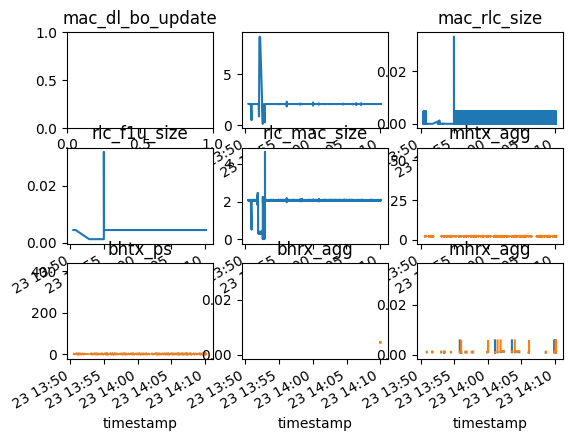

In [8]:
your_parser_instance = parser(file_name,anomaly_periods)
bhtx_df = your_parser_instance.parse_bhtx()
bhrx_df = your_parser_instance.parse_bhrx()
mhtx_df = your_parser_instance.parse_mhtx()
mhrx_df = your_parser_instance.parse_mhrx()
f1u_rlc_size_df = your_parser_instance.parse_f1u_rlc_size()
rlc_f1u_size_df = your_parser_instance.parse_rlc_f1u_size()
rlc_mac_size_df = your_parser_instance.parse_rlc_mac_size()
mac_rlc_size_df = your_parser_instance.parse_mac_rlc_size()
mac_bsr_update_df = your_parser_instance.parse_mac_bsr_update()
mac_csi_report_df = your_parser_instance.parse_mac_csi_report()
mac_dl_harq_df = your_parser_instance.parse_mac_dl_harq()
mac_sinr_update_df = your_parser_instance.parse_mac_sinr_update()
mac_ul_crc_ind_df = your_parser_instance.parse_mac_ul_crc_ind()
fapi_dl_config_df = your_parser_instance.parse_fapi_dl_config()
fapi_gnb_ul_config_req_df = your_parser_instance.parse_fapi_gnb_ul_config_req()
mac_dl_bo_update_df = your_parser_instance.parse_mac_dl_bo_update()

**Create KPIs Refrence Table:**

In [9]:
# get all timestamps to know start and end time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

## function to read all timestamps from the raw file (we need start and end time among all hooks)
def parse_time(file_name):
  f=open(file_name)
  all_timestamps =[]
  for line in f:
    # print (line)
    if "pcap" in line:
      continue  # Skip the line containing the unwanted string
    t=json.loads(line)
    try:
        tmp=json.loads(t['stream_payload_msg'])
        # print (tmp['timestamp'])
        all_timestamps.append(tmp['timestamp'])
    except KeyError:
      pass
  f.close()
  all_timestamps = list(set(all_timestamps)) # remove duplication
  all_timestamps.sort()
  all_timestamps = pd.DataFrame(all_timestamps, columns=['timestamp'])
  all_timestamps['timestamp'] = all_timestamps['timestamp'].astype(np.int64)
  all_timestamps = all_timestamps.sort_values(by='timestamp')
  all_timestamps['timestamp'] = pd.to_datetime(all_timestamps['timestamp'], unit='ns')
  return all_timestamps



def create_time_table(initial_datetime, final_datetime, time_step_ms):
    # Convert the initial_datetime and final_datetime to pandas datetime format
    initial_datetime = pd.to_datetime(initial_datetime)
    final_datetime = pd.to_datetime(final_datetime)

    # Calculate the number of rows based on the time difference
    num_rows = int((final_datetime - initial_datetime) / timedelta(milliseconds=time_step_ms)) + 1

    # Create a list of time steps using pandas date_range
    time_steps = pd.date_range(initial_datetime, periods=num_rows, freq=f"{time_step_ms}ms")

    # Create a pandas DataFrame with the 'time' column
    df = pd.DataFrame({'timestamp': time_steps})
    return df


all_timestamps = parse_time(file_name) # get all timestamps in the raw file
start_datetime = all_timestamps['timestamp'].iloc[0]
end_datetime = all_timestamps['timestamp'].iloc[-1]
time_step_ms = 150

Source_Table = create_time_table(start_datetime, end_datetime, time_step_ms)
Source_Table['timestamp'] = pd.to_datetime(Source_Table['timestamp'], unit='ns')

Source_Table

,timestamp
0,2023-08-23 13:50:26.084015104
1,2023-08-23 13:50:26.234015104
2,2023-08-23 13:50:26.384015104
3,2023-08-23 13:50:26.534015104
4,2023-08-23 13:50:26.684015104
...,...
7888,2023-08-23 14:10:09.284015104
7889,2023-08-23 14:10:09.434015104
7890,2023-08-23 14:10:09.584015104
7891,2023-08-23 14:10:09.734015104


In [10]:
logs_stats = {}
def merge_tables(Source_Table, tmp_df, KPI_Name):
  global logs_stats
  Source_Table = pd.merge_asof(left=Source_Table, right=tmp_df, on='timestamp',allow_exact_matches=True, direction="forward", tolerance=pd.Timedelta("200 milliseconds"))
  stats= {KPI_Name + ' Number before merging:':len(tmp_df),
              KPI_Name + ' Number after merging:':len(Source_Table) -Source_Table[KPI_Name].isna().sum(),
              KPI_Name + ' Succes merging rate:':round(Source_Table[KPI_Name].notna().sum()/len(tmp_df)*100,3)}
  logs_stats.update(stats)

  return  Source_Table

Source_Table = merge_tables(Source_Table, bhtx_df[bhtx_df['BHTX_In_size'].notna()].filter(regex='^BHTX_In_'),'BHTX_In_size')
Source_Table = merge_tables(Source_Table, bhtx_df[bhtx_df['BHTX_Out_size'].notna()].filter(regex='^BHTX_Out_'),'BHTX_Out_size')
Source_Table = merge_tables(Source_Table, bhrx_df[bhrx_df['BHRX_In_size'].notna()].filter(regex='^BHRX_In_'),'BHRX_In_size')
Source_Table = merge_tables(Source_Table, bhrx_df[bhrx_df['BHRX_Out_size'].notna()].filter(regex='^BHRX_Out_'),'BHRX_Out_size')

Source_Table = merge_tables(Source_Table, mhtx_df[mhtx_df['MHTX_In_size'].notna()].filter(regex='^MHTX_In_'),'MHTX_In_size')
Source_Table = merge_tables(Source_Table, mhtx_df[mhtx_df['MHTX_Out_size'].notna()].filter(regex='^MHTX_Out_'),'MHTX_Out_size')
Source_Table = merge_tables(Source_Table, mhrx_df[mhrx_df['MHRX_In_size'].notna()].filter(regex='^MHRX_In_'),'MHRX_In_size')
Source_Table = merge_tables(Source_Table, mhrx_df[mhrx_df['MHRX_Out_size'].notna()].filter(regex='^MHRX_Out_'),'MHRX_Out_size')

Source_Table = merge_tables(Source_Table, f1u_rlc_size_df[f1u_rlc_size_df['f1u_rlc_size'].notna()].filter(regex='^f1u_rlc_'),'f1u_rlc_size')

Source_Table = merge_tables(Source_Table, rlc_f1u_size_df[rlc_f1u_size_df['rlc_f1u_size'].notna()].filter(regex='^rlc_f1u_'),'rlc_f1u_size')
Source_Table = merge_tables(Source_Table, rlc_mac_size_df[rlc_mac_size_df['rlc_mac_size'].notna()].filter(regex='^rlc_mac_'),'rlc_mac_size')
Source_Table = merge_tables(Source_Table, mac_rlc_size_df[mac_rlc_size_df['mac_rlc_size'].notna()].filter(regex='^mac_rlc_'),'mac_rlc_size')
Source_Table = merge_tables(Source_Table, mac_bsr_update_df[mac_bsr_update_df['mac_bsr_update_max'].notna()].filter(regex='^mac_bsr_update_'),'mac_bsr_update_max')
Source_Table = merge_tables(Source_Table, mac_csi_report_df[mac_csi_report_df['mac_csi_report_max'].notna()].filter(regex='^mac_csi_report_'),'mac_csi_report_max')
Source_Table = merge_tables(Source_Table, mac_dl_harq_df[mac_dl_harq_df['mac_dl_harq_total'].notna()].filter(regex='^mac_dl_harq_'),'mac_dl_harq_total')
Source_Table = merge_tables(Source_Table, mac_sinr_update_df[mac_sinr_update_df['mac_sinr_update_max'].notna()].filter(regex='^mac_sinr_update_'),'mac_sinr_update_max')
Source_Table = merge_tables(Source_Table, mac_ul_crc_ind_df[mac_ul_crc_ind_df['mac_ul_CRC_Max'].notna()].filter(regex='^mac_ul_CRC_'),'mac_ul_CRC_Max')
Source_Table = merge_tables(Source_Table, fapi_dl_config_df[fapi_dl_config_df['l1_tx'].notna()].filter(regex='^l1_'),'l1_tx')
Source_Table = merge_tables(Source_Table, fapi_gnb_ul_config_req_df[fapi_gnb_ul_config_req_df['l1_UL_tx'].notna()].filter(regex='^l1_'),'l1_UL_tx')
Source_Table = merge_tables(Source_Table, mac_dl_bo_update_df[mac_dl_bo_update_df['mac_dl_bo_max'].notna()].filter(regex='^mac_dl_bo_'),'mac_dl_bo_max')



In [11]:
# assin anomaly periods
Source_Table.set_index('timestamp', inplace=True)
Source_Table['anomaly'] = 0
for i in range(len(anomaly_periods)):
    t=Source_Table.between_time(anomaly_periods.loc[i]['start_time'].time(), anomaly_periods.loc[i]['end_time'].time())['anomaly']
    for j in range(len(t.index)):
        Source_Table.at[t.index[j],'anomaly']=1


### Generate CSV

In [12]:
# Source_Table.isna().sum().to_csv('/content/NA_table.csv')

Source_Table.fillna(0, inplace=True)

# Source_Table.to_csv('/content/All_Radio_KPIs.csv')
Source_Table.to_csv(parsed_file_name+"radio.csv")

## Checks


Time Duration: 0 days 00:19:43.800262144
First Time: 2023-08-23 13:50:26.084474112
Last Time: 2023-08-23 14:10:09.884736256


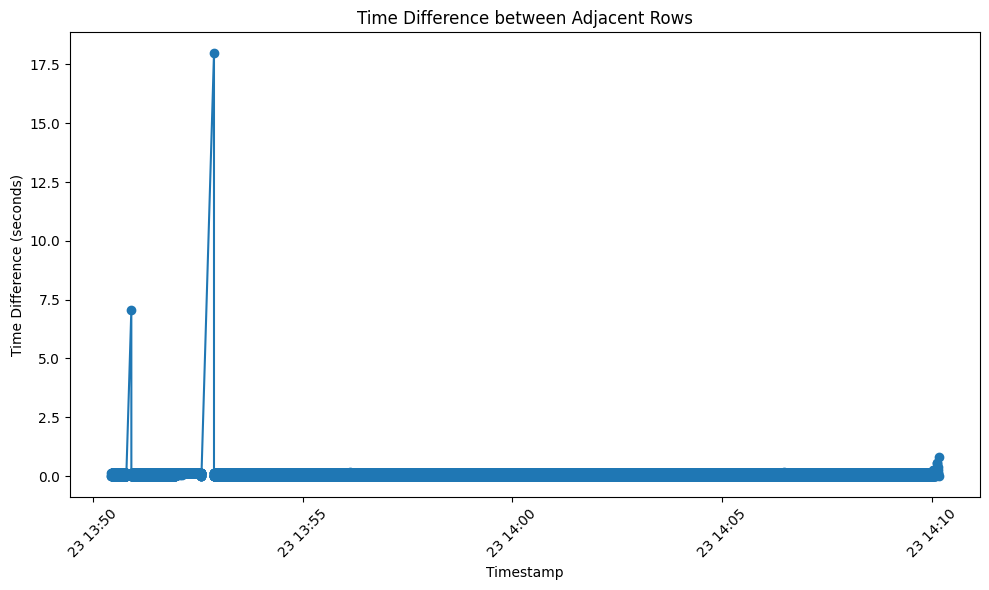

In [13]:
# df = bhtx_df[bhtx_df['BHTX_In_size'].notna()].filter(regex='^BHTX_In_')
df = bhtx_df

first_time = df.index[0]
last_time = df.index[-1]
time_duration = last_time - first_time
print(f"Time Duration: {time_duration}")
print(f"First Time: {first_time}")
print(f"Last Time: {last_time}")

df.index = pd.to_datetime(df.index)
df['Time_Diff'] = df.index.to_series().diff()



plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Time_Diff'].dt.total_seconds(), marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Time Difference (seconds)')
plt.title('Time Difference between Adjacent Rows')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.ylim(0,5)
plt.savefig("./Plot_Radio_KPIs_Time_Diff_BHTX_" + parsed_file_name + ".jpg", format='jpg')
plt.show()

**stream_sn2 Checker:**

In [14]:
import pandas as pd

def check_sequence_increase(df, column_name):

    df_sorted = df.sort_values(by=column_name)
    last_sequence_number = None
    indices_with_large_increase = []
    for index, row in df_sorted.iterrows():
        current_sequence_number = row[column_name]
        if last_sequence_number is not None and current_sequence_number - last_sequence_number > 1:
            indices_with_large_increase.append(index)
        last_sequence_number = current_sequence_number

    # Return the indices of rows where the increase is more than 1
    return indices_with_large_increase

df = bhtx_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for bhtx_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)


df = bhrx_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for bhrx_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = mhtx_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mhtx_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = mhrx_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mhrx_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = f1u_rlc_size_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for f1u_rlc_size_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = rlc_f1u_size_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for rlc_f1u_size_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = rlc_mac_size_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for rlc_mac_size_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)

df = mac_rlc_size_df
indices_with_large_increase = check_sequence_increase(df, 'stream_sn2')
print("Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mac_rlc_size_df:",len(indices_with_large_increase),"/", len(df), len(indices_with_large_increase)/len(df)*100)


Number of rows with stream_sn2 diff bigger than one / Total Number of rows for bhtx_df: 21 / 16915 0.12415016257759386
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for bhrx_df: 0 / 1867 0.0
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mhtx_df: 10 / 16644 0.0600817111271329
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mhrx_df: 16 / 16642 0.09614229059007331
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for f1u_rlc_size_df: 22 / 8319 0.2644548623632648
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for rlc_f1u_size_df: 3 / 930 0.3225806451612903
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for rlc_mac_size_df: 20 / 8603 0.2324770428920144
Number of rows with stream_sn2 diff bigger than one / Total Number of rows for mac_rlc_size_df: 20 / 8306 0.24078979051288227


## Platform KPIs parser:

In [15]:
def my_pivot(platform_df, col, new_colummn):
    data ={}
    for i in platform_df['Process_And_Thread'].unique():
        data[i] = []
    for i in platform_df['timestamp'].unique():
        tdf = platform_df[platform_df['timestamp'] == i]
        for j in tdf[col].unique():
            data[j].append({i:tdf[tdf[col]==j][new_colummn].values[0]})
        # Create a dictionary of DataFrames for each key
    dfs = {}
    for key, values in data.items():
        timestamp_data = {}
        for entry in values:
            timestamp, runtime = entry.popitem()
            timestamp_data[timestamp] = runtime
        df = pd.DataFrame.from_dict(timestamp_data, orient='index',columns=[f'{key}_{new_colummn}'])
        dfs[key] = df

    # Merge the DataFrames using outer join
    merged_df = pd.concat(list(dfs.values()), axis=1, join='outer')
    merged_df.fillna(0, inplace=True)
    # Display the resulting merged DataFrame
    return merged_df


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3209005/2980673641.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return float(np.mean((data - np.mean(data))**3) / (np.std(data)**3))
/tmp/ipykernel_3209005/2980673641.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return float(np.mean((data - np.mean(data))**4) / (np.std(data)**4))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWar

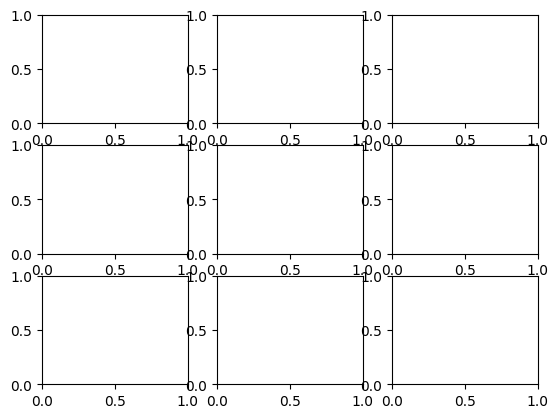

In [16]:
your_parser_instance = parser(file_name,anomaly_periods)
platform_df = your_parser_instance.parse_platform()
# Filter the rows that do not start with 'OS swapper' or 'kworker' in 'thread_name' column
platform_df = platform_df[~platform_df['thread_name'].str.startswith(('OS swapper', 'kworker', 'stress-ng', 'unknown', 'irq/', 'irq_work', 'ksoftirqd', 'rcuc/'))]

platform_df['Process_And_Thread'] = platform_df['process_name'] + '_' + platform_df['thread_name']

# If you want to reset the index after removing rows
platform_df = platform_df.reset_index()

# Sort by timestamp and Process_And_Thread column
platform_df = platform_df.sort_values(by=['timestamp','Process_And_Thread'], ascending=True)

# df.drop_duplicates(['timestamp', 'Process_And_Thread'], inplace=True)

# calculate mean, var, std, ....outliers
for index, row in platform_df.iterrows():
  bin_value = row['bins']
  # print ('real max:',row['max'])
  mean, var ,std, skewness, kurtosis, irq,  outliers = your_parser_instance.calc_platform_hist(bin_value)
  platform_df.loc[index, 'mean']= mean
  platform_df.loc[index, 'var']= var
  platform_df.loc[index, 'std']= std
  platform_df.loc[index, 'skewness']= skewness
  platform_df.loc[index, 'kurtosis']= kurtosis
  platform_df.loc[index, 'irq']= irq
  platform_df.loc[index, 'outliers']= outliers
  # =========== calc min and Range====================================
  i = 0
  bin_count = row['bins'][i]
  range_start = 2 ** i
  range_end = 2 ** (i + 1) - 1
  range_size = range_end - range_start + 1
  items_per_bin = bin_count / range_size
  # Calculate total for this bin using formulas
  Min_value = ((range_start + range_end) * range_size/2)*items_per_bin
  # print ("range_start, range_end, bin_count, value:",range_start, range_end, bin_count, value)
  platform_df.loc[index, 'range'] = row['max_runtime'] - Min_value
  # print ("row['max'],  Min_value:",row['max'],  Min_value)

  # ============ calc min ===============================

# histogram for sum for all threads
for index, row in platform_df.iterrows():
  bin_value = row['others_runtime_bin']
  # print ('real max:',row['max'])
  mean, var ,std, skewness, kurtosis, irq,  outliers = your_parser_instance.calc_platform_hist(bin_value)
  platform_df.loc[index, 'others_runtime_mean']= mean
  platform_df.loc[index, 'others_runtime_var']= var
  platform_df.loc[index, 'others_runtime_std']= std
  platform_df.loc[index, 'others_runtime_skewness']= skewness
  platform_df.loc[index, 'others_runtime_kurtosis']= kurtosis
  platform_df.loc[index, 'others_runtime_irq']= irq
  platform_df.loc[index, 'others_runtime_outliers']= outliers
  # =========== calc min and Range====================================
  i = 0
  bin_count = row['others_runtime_bin'][i]
  range_start = 2 ** i
  range_end = 2 ** (i + 1) - 1
  range_size = range_end - range_start + 1
  items_per_bin = bin_count / range_size
  # Calculate total for this bin using formulas
  Min_value = ((range_start + range_end) * range_size/2)*items_per_bin
  # print ("range_start, range_end, bin_count, value:",range_start, range_end, bin_count, value)
  platform_df.loc[index, 'others_runtime_range'] = row['max_runtime'] - Min_value
  # print ("row['max'],  Min_value:",row['max'],  Min_value)


In [17]:

platform_mean_df = my_pivot(platform_df, 'Process_And_Thread', 'mean')
platform_var_df = my_pivot(platform_df, 'Process_And_Thread', 'var')
platform_std_df = my_pivot(platform_df, 'Process_And_Thread', 'std')
platform_range_df = my_pivot(platform_df, 'Process_And_Thread', 'range')
platform_skewness_df = my_pivot(platform_df, 'Process_And_Thread', 'skewness')
platform_kurtosis_df = my_pivot(platform_df, 'Process_And_Thread', 'kurtosis')
platform_irq_df = my_pivot(platform_df, 'Process_And_Thread', 'irq')
platform_outliers_df = my_pivot(platform_df, 'Process_And_Thread', 'outliers')
platform_others_runtime_mean_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_mean')
platform_others_runtime_var_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_var')
platform_others_runtime_std_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_std')
platform_others_runtime_range_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_range')
platform_others_runtime_skewness_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_skewness')
platform_others_runtime_kurtosis_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_kurtosis')
platform_others_runtime_irq_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_irq')
platform_others_runtime_outliers_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime_outliers')
platform_max_df = my_pivot(platform_df, 'Process_And_Thread', 'max')
platform_total_events_df = my_pivot(platform_df, 'Process_And_Thread', 'total_events')
platform_total_runtime_df = my_pivot(platform_df, 'Process_And_Thread', 'total_runtime')
platform_max_runtime_df = my_pivot(platform_df, 'Process_And_Thread', 'max_runtime')
platform_others_runtime_df = my_pivot(platform_df, 'Process_And_Thread', 'others_runtime')
platform_anomaly_df = my_pivot(platform_df, 'Process_And_Thread', 'anomaly')
platform_anomaly_df.rename(columns={'gnb_cu_pdcp_0_0_pdcp_master_0_anomaly': 'anomaly'}, inplace=True)




In [18]:
All_Platform_KPIs_df = pd.concat([platform_max_df, platform_total_events_df, platform_total_runtime_df,platform_mean_df, platform_range_df,platform_var_df,platform_std_df,platform_skewness_df ,platform_kurtosis_df,platform_irq_df,platform_outliers_df, platform_others_runtime_mean_df, platform_others_runtime_var_df, platform_others_runtime_std_df, platform_others_runtime_range_df, platform_others_runtime_skewness_df, platform_others_runtime_kurtosis_df, platform_others_runtime_irq_df, platform_others_runtime_outliers_df ,platform_max_runtime_df, platform_others_runtime_df, platform_anomaly_df['anomaly']], axis=1)
All_Platform_KPIs_df.reset_index(inplace=True)
All_Platform_KPIs_df.fillna(0, inplace=True)
# All_Platform_KPIs_df.to_csv("./All_Platform_KPIs_df.csv")

/tmp/ipykernel_3209005/2177811893.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  All_Platform_KPIs_df.reset_index(inplace=True)


In [19]:
All_Platform_KPIs_df.rename(columns={'index': 'timestamp'}, inplace=True)

In [20]:
# platform_df.rename(columns={'index': 'anomaly'}, inplace=True)


In [21]:
All_Platform_KPIs_df

,timestamp,dumgr_du_1_DUMGR_LOGGER_1_max,gnb_cu_pdcp_0_0_pdcp_master_0_max,gnb_cu_pdcp_0_0_pdcp_worker_0_max,gnb_cu_pdcp_0_0_recv_data_0_max,gnb_cu_pdcp_0_0_x2_worker_0_max,gnb_du_layer2_SlotHlr_DU1_C0_max,gnb_du_layer2_TxCtrl_DU1_C0_max,gnb_du_layer2_f1_du_worker_0_max,gnb_du_layer2_pr_accumulator_max,...,l1app_main_ebbupool_act_2_others_runtime,l1app_main_ebbupool_act_3_others_runtime,l1app_main_fh_main_poll-5_others_runtime,l1app_main_fh_rx_bbdev-18_others_runtime,phc2sys_phc2sys_others_runtime,ptp4l_ptp4l_others_runtime,gnb_cu_l3_l3_main_others_runtime,dumgr_du_1_dumgr_du_1_others_runtime,gnb_cu_l3_l3_uecc_1_others_runtime,anomaly
0,1900-01-01 13:50:26.959321,85.0,5.0,19.0,29.0,4.0,23.0,46.0,18.0,4.0,...,346.0,264.5,1043248.5,1370472.5,7366.0,536.0,0.0,0.0,0.0,0.0
1,1900-01-01 13:50:28.076284,3.0,5.0,19.0,34.0,4.0,28.0,45.0,18.0,3.0,...,319.0,227.0,1025101.0,1339331.5,11228.0,547.5,261696.0,0.0,0.0,0.0
2,1900-01-01 13:50:29.167259,93.0,5.0,19.0,13.0,5.0,21.0,47.0,18.0,4.0,...,328.5,290.5,1046724.5,1353101.5,8907.0,541.5,264213.0,0.0,0.0,0.0
3,1900-01-01 13:50:30.273064,4.0,5.0,19.0,12.0,4.0,27.0,45.0,19.0,5.0,...,260.5,279.5,1033973.0,1339563.0,9091.5,509.0,262090.5,0.0,0.0,0.0
4,1900-01-01 13:50:31.363781,56.0,5.0,20.0,16.0,4.0,33.0,47.0,20.0,3.0,...,309.0,203.0,1032929.0,1342604.5,9664.0,542.0,262425.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,1900-01-01 14:10:05.358778,0.0,4.0,0.0,13.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1345372.5,24859.5,560.0,263009.0,0.0,0.0,0.0
1067,1900-01-01 14:10:06.456914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,218.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1068,1900-01-01 14:10:07.558508,82.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,1348324.5,0.0,0.0,0.0,0.0,0.0,0.0
1069,1900-01-01 14:10:08.659018,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,345.5,0.0,1026417.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_3209005/3207602818.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['time_diff'] = df['timestamp'].diff().dt.total_seconds()


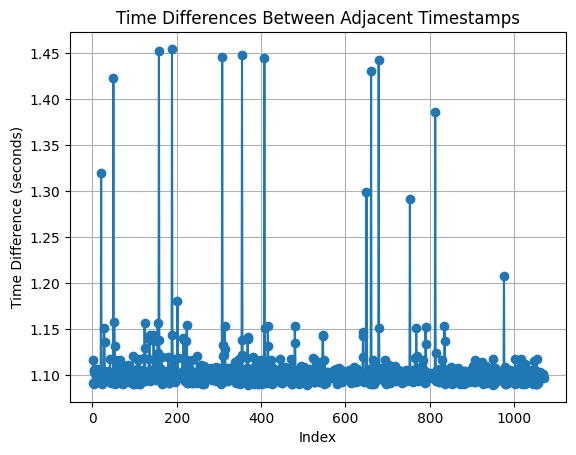

In [22]:

df = All_Platform_KPIs_df
# Convert the timestamp column to datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the time differences between adjacent timestamps
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

# Plot the time differences
plt.plot(df['time_diff'], marker='o')
plt.xlabel('Index')
plt.ylabel('Time Difference (seconds)')
plt.title('Time Differences Between Adjacent Timestamps')
plt.grid(True)
plt.savefig("./Plot_Platform_KPIs_Time_Diff_" + parsed_file_name + ".jpg", format='jpg')
plt.show()

**Ethernet Port Traffic Parser:**

In [23]:
# this "or tmp['name']=='Ethernet9/2'"  is not required
# this is midhaul traffic

Ethernet_Port_df=pd.DataFrame()

f=open(file_name)

data =[]

for i in f:

    t=json.loads(i)

    try:

        if(t['host_name']=='5gmgmt'):

            tmp=json.loads(t['stream_payload_msg'])

            if(tmp['name']=='Ethernet31/1' or tmp['name']=='Ethernet15/2'):  #31/1 RU port, 15/2 DU Port

                holder={}

                holder['timestamp']=t['stream_payload_time']

                holder['stream_sn']=t['stream_sn']

                holder['name']=tmp['name']

                holder['anomaly']=0

                holder['in_octet_total'] = tmp['in-octets']

                holder['out_octet_total'] = tmp['out-octets']

                data.append(holder)

    except KeyError:

        pass

f.close()

len(data)

Ethernet_Port_df = pd.DataFrame.from_dict(data)

Ethernet_Port_df['timestamp'] = pd.to_datetime(Ethernet_Port_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')


Ethernet_Port_df=Ethernet_Port_df.sort_values(by='timestamp', ascending=True)

# PTP_df.set_index('timestamp', inplace=True)

# Pivot table
Ethernet_Port_pivot_df = pd.pivot_table(Ethernet_Port_df,
                            index='timestamp',
                            columns='name',
                            values=['in_octet_total', 'out_octet_total'])

Ethernet_Port_pivot_df.columns = [f"{col[0]}_{col[1]}" for col in Ethernet_Port_pivot_df.columns]

# remove the accumlated value
for i in Ethernet_Port_pivot_df.columns:
  Ethernet_Port_pivot_df[i] = Ethernet_Port_pivot_df[i].diff(periods=2)
  Ethernet_Port_pivot_df[i]*=(8/10) # divide by 10 [s] as we substract two time steps each one with 5 [s]
  Ethernet_Port_pivot_df[i]/=1000*1000*1000


Ethernet_Port_pivot_df = Ethernet_Port_pivot_df.reset_index(drop=False)

# Ethernet_Port_pivot_df.to_csv('/content/Ethernet_Port.csv')

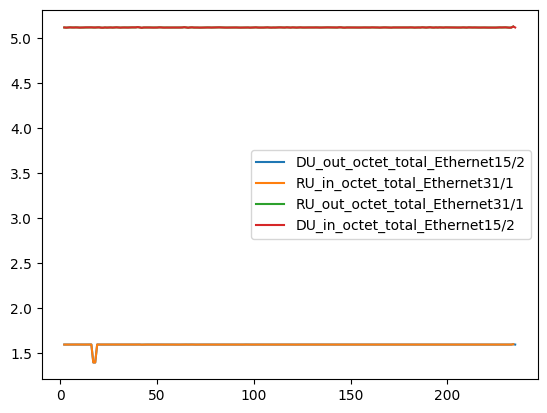

In [24]:
Ethernet_Port_pivot_df['out_octet_total_Ethernet15/2'].plot(label = 'DU_out_octet_total_Ethernet15/2')
Ethernet_Port_pivot_df['in_octet_total_Ethernet31/1'].plot(label = 'RU_in_octet_total_Ethernet31/1')
Ethernet_Port_pivot_df['out_octet_total_Ethernet31/1'].plot(label = 'RU_out_octet_total_Ethernet31/1')
Ethernet_Port_pivot_df['in_octet_total_Ethernet15/2'].plot(label = 'DU_in_octet_total_Ethernet15/2')

# plt.savefig("./Plot_Etherent_Ports_" + parsed_file_name + ".jpg", format='jpg')
plt.legend()

['timestamp',
 'dumgr_du_1_DUMGR_LOGGER_1_max',
 'dumgr_du_1_dumgr_du_1_max',
 'gnb_cu_l3_l3_main_max',
 'gnb_cu_pdcp_0_0_f1_worker_0_max',
 'gnb_cu_pdcp_0_0_pdcp_master_0_max',
 'gnb_cu_pdcp_0_0_pdcp_worker_0_max',
 'gnb_cu_pdcp_0_0_recv_data_0_max',
 'gnb_du_layer2_LowPrio_DU1_C0_max',
 'gnb_du_layer2_TxCtrl_DU1_C0_max',
 'gnb_du_layer2_f1_du_worker_0_max',
 'gnb_du_layer2_pr_accumulator_max',
 'gnb_du_layer2_rlcAccum_DU1_max',
 'gnb_du_layer2_rlcTimer_DU1_max',
 'gnb_du_layer2_rlcWorkrDU1_\x01_max',
 'l1app_main_ebbupool_act_0_max',
 'l1app_main_ebbupool_act_1_max',
 'l1app_main_ebbupool_act_2_max',
 'l1app_main_ebbupool_act_3_max',
 'l1app_main_fh_main_poll-22_max',
 'l1app_main_fh_rx_bbdev-21_max',
 'phc2sys_phc2sys_max',
 'ptp4l_ptp4l_max',
 'dumgr_du_1_DUMGR_LOGGER_1_total_events',
 'dumgr_du_1_dumgr_du_1_total_events',
 'gnb_cu_l3_l3_main_total_events',
 'gnb_cu_pdcp_0_0_f1_worker_0_total_events',
 'gnb_cu_pdcp_0_0_pdcp_master_0_total_events',
 'gnb_cu_pdcp_0_0_pdcp_worker_0_to

**Merge Platform and Ethernet Port KPIs:**

Number of not exist columns filled with zeros are:  55


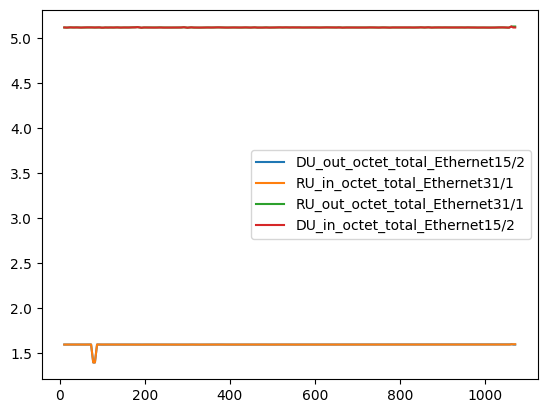

In [35]:
#correct the date of the platform KPIs from the right date got it from Ethernet_Port_pivot_df
All_Platform_KPIs_df['timestamp'] = All_Platform_KPIs_df['timestamp'].apply(lambda x: x.replace(year=Ethernet_Port_pivot_df.loc[0, 'timestamp'].year, month=Ethernet_Port_pivot_df.loc[0, 'timestamp'].month, day=Ethernet_Port_pivot_df.loc[0, 'timestamp'].day))

All_Platform_KPIs_and_Ethernet_Port_df = pd.merge_asof(left=All_Platform_KPIs_df, right=Ethernet_Port_pivot_df, on='timestamp',allow_exact_matches=True, direction="forward", tolerance=pd.Timedelta("1150 milliseconds"))

# imputing:
All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet15/2'] = All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet15/2'].interpolate(method='linear')
All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet15/2'] = All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet15/2'].interpolate(method='linear')
All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet31/1'] = All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet31/1'].interpolate(method='linear')
All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet31/1'] = All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet31/1'].interpolate(method='linear')

# plotting:
All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet15/2'].plot(label = 'DU_out_octet_total_Ethernet15/2')
All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet31/1'].plot(label = 'RU_in_octet_total_Ethernet31/1')
All_Platform_KPIs_and_Ethernet_Port_df['out_octet_total_Ethernet31/1'].plot(label = 'RU_out_octet_total_Ethernet31/1')
All_Platform_KPIs_and_Ethernet_Port_df['in_octet_total_Ethernet15/2'].plot(label = 'DU_in_octet_total_Ethernet15/2')
plt.legend()

All_Platform_KPIs_and_Ethernet_Port_df.fillna(0, inplace=True)

# using col name filtered by chaunhao

col_names = 'timestamp,dumgr_du_1_DUMGR_LOGGER_1_max,dumgr_du_1_dumgr_du_1_max,gnb_cu_l3_l3_main_max,gnb_cu_pdcp_0_0_f1_worker_0_max,gnb_cu_pdcp_0_0_pdcp_master_0_max,gnb_cu_pdcp_0_0_pdcp_worker_0_max,gnb_cu_pdcp_0_0_recv_data_0_max,gnb_du_layer2_LowPrio_DU1_C0_max,gnb_du_layer2_TxCtrl_DU1_C0_max,gnb_du_layer2_f1_du_worker_0_max,gnb_du_layer2_pr_accumulator_max,gnb_du_layer2_rlcAccum_DU1_max,gnb_du_layer2_rlcTimer_DU1_max,gnb_du_layer2_rlcWorkrDU1__max,l1app_main_ebbupool_act_0_max,l1app_main_ebbupool_act_1_max,l1app_main_ebbupool_act_2_max,l1app_main_ebbupool_act_3_max,l1app_main_fh_main_poll-22_max,l1app_main_fh_rx_bbdev-21_max,phc2sys_phc2sys_max,ptp4l_ptp4l_max,dumgr_du_1_DUMGR_LOGGER_1_total_events,dumgr_du_1_dumgr_du_1_total_events,gnb_cu_l3_l3_main_total_events,gnb_cu_pdcp_0_0_f1_worker_0_total_events,gnb_cu_pdcp_0_0_pdcp_master_0_total_events,gnb_cu_pdcp_0_0_pdcp_worker_0_total_events,gnb_cu_pdcp_0_0_recv_data_0_total_events,gnb_du_layer2_LowPrio_DU1_C0_total_events,gnb_du_layer2_TxCtrl_DU1_C0_total_events,gnb_du_layer2_f1_du_worker_0_total_events,gnb_du_layer2_pr_accumulator_total_events,gnb_du_layer2_rlcAccum_DU1_total_events,gnb_du_layer2_rlcTimer_DU1_total_events,gnb_du_layer2_rlcWorkrDU1__total_events,l1app_main_ebbupool_act_0_total_events,l1app_main_ebbupool_act_1_total_events,l1app_main_ebbupool_act_2_total_events,l1app_main_ebbupool_act_3_total_events,l1app_main_fh_main_poll-22_total_events,l1app_main_fh_rx_bbdev-21_total_events,phc2sys_phc2sys_total_events,ptp4l_ptp4l_total_events,dumgr_du_1_DUMGR_LOGGER_1_total_runtime,dumgr_du_1_dumgr_du_1_total_runtime,gnb_cu_l3_l3_main_total_runtime,gnb_cu_pdcp_0_0_f1_worker_0_total_runtime,gnb_cu_pdcp_0_0_pdcp_master_0_total_runtime,gnb_cu_pdcp_0_0_pdcp_worker_0_total_runtime,gnb_cu_pdcp_0_0_recv_data_0_total_runtime,gnb_du_layer2_LowPrio_DU1_C0_total_runtime,gnb_du_layer2_TxCtrl_DU1_C0_total_runtime,gnb_du_layer2_f1_du_worker_0_total_runtime,gnb_du_layer2_pr_accumulator_total_runtime,gnb_du_layer2_rlcAccum_DU1_total_runtime,gnb_du_layer2_rlcTimer_DU1_total_runtime,gnb_du_layer2_rlcWorkrDU1__total_runtime,l1app_main_ebbupool_act_0_total_runtime,l1app_main_ebbupool_act_1_total_runtime,l1app_main_ebbupool_act_2_total_runtime,l1app_main_ebbupool_act_3_total_runtime,l1app_main_fh_main_poll-22_total_runtime,l1app_main_fh_rx_bbdev-21_total_runtime,phc2sys_phc2sys_total_runtime,ptp4l_ptp4l_total_runtime,dumgr_du_1_DUMGR_LOGGER_1_mean,dumgr_du_1_dumgr_du_1_mean,gnb_cu_l3_l3_main_mean,gnb_cu_pdcp_0_0_f1_worker_0_mean,gnb_cu_pdcp_0_0_pdcp_master_0_mean,gnb_cu_pdcp_0_0_pdcp_worker_0_mean,gnb_cu_pdcp_0_0_recv_data_0_mean,gnb_du_layer2_LowPrio_DU1_C0_mean,gnb_du_layer2_TxCtrl_DU1_C0_mean,gnb_du_layer2_f1_du_worker_0_mean,gnb_du_layer2_pr_accumulator_mean,gnb_du_layer2_rlcAccum_DU1_mean,gnb_du_layer2_rlcTimer_DU1_mean,gnb_du_layer2_rlcWorkrDU1__mean,l1app_main_ebbupool_act_0_mean,l1app_main_ebbupool_act_1_mean,l1app_main_ebbupool_act_2_mean,l1app_main_ebbupool_act_3_mean,l1app_main_fh_main_poll-22_mean,l1app_main_fh_rx_bbdev-21_mean,phc2sys_phc2sys_mean,ptp4l_ptp4l_mean,dumgr_du_1_DUMGR_LOGGER_1_range,dumgr_du_1_dumgr_du_1_range,gnb_cu_l3_l3_main_range,gnb_cu_pdcp_0_0_f1_worker_0_range,gnb_cu_pdcp_0_0_pdcp_master_0_range,gnb_cu_pdcp_0_0_pdcp_worker_0_range,gnb_cu_pdcp_0_0_recv_data_0_range,gnb_du_layer2_LowPrio_DU1_C0_range,gnb_du_layer2_TxCtrl_DU1_C0_range,gnb_du_layer2_f1_du_worker_0_range,gnb_du_layer2_pr_accumulator_range,gnb_du_layer2_rlcAccum_DU1_range,gnb_du_layer2_rlcTimer_DU1_range,gnb_du_layer2_rlcWorkrDU1__range,l1app_main_ebbupool_act_0_range,l1app_main_ebbupool_act_1_range,l1app_main_ebbupool_act_2_range,l1app_main_ebbupool_act_3_range,l1app_main_fh_main_poll-22_range,l1app_main_fh_rx_bbdev-21_range,phc2sys_phc2sys_range,ptp4l_ptp4l_range,dumgr_du_1_DUMGR_LOGGER_1_var,dumgr_du_1_dumgr_du_1_var,gnb_cu_l3_l3_main_var,gnb_cu_pdcp_0_0_f1_worker_0_var,gnb_cu_pdcp_0_0_pdcp_master_0_var,gnb_cu_pdcp_0_0_pdcp_worker_0_var,gnb_cu_pdcp_0_0_recv_data_0_var,gnb_du_layer2_LowPrio_DU1_C0_var,gnb_du_layer2_TxCtrl_DU1_C0_var,gnb_du_layer2_f1_du_worker_0_var,gnb_du_layer2_pr_accumulator_var,gnb_du_layer2_rlcAccum_DU1_var,gnb_du_layer2_rlcTimer_DU1_var,gnb_du_layer2_rlcWorkrDU1__var,l1app_main_ebbupool_act_0_var,l1app_main_ebbupool_act_1_var,l1app_main_ebbupool_act_2_var,l1app_main_ebbupool_act_3_var,l1app_main_fh_main_poll-22_var,l1app_main_fh_rx_bbdev-21_var,phc2sys_phc2sys_var,ptp4l_ptp4l_var,dumgr_du_1_DUMGR_LOGGER_1_std,dumgr_du_1_dumgr_du_1_std,gnb_cu_l3_l3_main_std,gnb_cu_pdcp_0_0_f1_worker_0_std,gnb_cu_pdcp_0_0_pdcp_master_0_std,gnb_cu_pdcp_0_0_pdcp_worker_0_std,gnb_cu_pdcp_0_0_recv_data_0_std,gnb_du_layer2_LowPrio_DU1_C0_std,gnb_du_layer2_TxCtrl_DU1_C0_std,gnb_du_layer2_f1_du_worker_0_std,gnb_du_layer2_pr_accumulator_std,gnb_du_layer2_rlcAccum_DU1_std,gnb_du_layer2_rlcTimer_DU1_std,gnb_du_layer2_rlcWorkrDU1__std,l1app_main_ebbupool_act_0_std,l1app_main_ebbupool_act_1_std,l1app_main_ebbupool_act_2_std,l1app_main_ebbupool_act_3_std,l1app_main_fh_main_poll-22_std,l1app_main_fh_rx_bbdev-21_std,phc2sys_phc2sys_std,ptp4l_ptp4l_std,dumgr_du_1_DUMGR_LOGGER_1_skewness,dumgr_du_1_dumgr_du_1_skewness,gnb_cu_l3_l3_main_skewness,gnb_cu_pdcp_0_0_f1_worker_0_skewness,gnb_cu_pdcp_0_0_pdcp_master_0_skewness,gnb_cu_pdcp_0_0_pdcp_worker_0_skewness,gnb_cu_pdcp_0_0_recv_data_0_skewness,gnb_du_layer2_LowPrio_DU1_C0_skewness,gnb_du_layer2_TxCtrl_DU1_C0_skewness,gnb_du_layer2_f1_du_worker_0_skewness,gnb_du_layer2_pr_accumulator_skewness,gnb_du_layer2_rlcAccum_DU1_skewness,gnb_du_layer2_rlcTimer_DU1_skewness,gnb_du_layer2_rlcWorkrDU1__skewness,l1app_main_ebbupool_act_0_skewness,l1app_main_ebbupool_act_1_skewness,l1app_main_ebbupool_act_2_skewness,l1app_main_ebbupool_act_3_skewness,l1app_main_fh_main_poll-22_skewness,l1app_main_fh_rx_bbdev-21_skewness,phc2sys_phc2sys_skewness,ptp4l_ptp4l_skewness,dumgr_du_1_DUMGR_LOGGER_1_kurtosis,dumgr_du_1_dumgr_du_1_kurtosis,gnb_cu_l3_l3_main_kurtosis,gnb_cu_pdcp_0_0_f1_worker_0_kurtosis,gnb_cu_pdcp_0_0_pdcp_master_0_kurtosis,gnb_cu_pdcp_0_0_pdcp_worker_0_kurtosis,gnb_cu_pdcp_0_0_recv_data_0_kurtosis,gnb_du_layer2_LowPrio_DU1_C0_kurtosis,gnb_du_layer2_TxCtrl_DU1_C0_kurtosis,gnb_du_layer2_f1_du_worker_0_kurtosis,gnb_du_layer2_pr_accumulator_kurtosis,gnb_du_layer2_rlcAccum_DU1_kurtosis,gnb_du_layer2_rlcTimer_DU1_kurtosis,gnb_du_layer2_rlcWorkrDU1__kurtosis,l1app_main_ebbupool_act_0_kurtosis,l1app_main_ebbupool_act_1_kurtosis,l1app_main_ebbupool_act_2_kurtosis,l1app_main_ebbupool_act_3_kurtosis,l1app_main_fh_main_poll-22_kurtosis,l1app_main_fh_rx_bbdev-21_kurtosis,phc2sys_phc2sys_kurtosis,ptp4l_ptp4l_kurtosis,dumgr_du_1_DUMGR_LOGGER_1_irq,dumgr_du_1_dumgr_du_1_irq,gnb_cu_l3_l3_main_irq,gnb_cu_pdcp_0_0_f1_worker_0_irq,gnb_cu_pdcp_0_0_pdcp_master_0_irq,gnb_cu_pdcp_0_0_pdcp_worker_0_irq,gnb_cu_pdcp_0_0_recv_data_0_irq,gnb_du_layer2_LowPrio_DU1_C0_irq,gnb_du_layer2_TxCtrl_DU1_C0_irq,gnb_du_layer2_f1_du_worker_0_irq,gnb_du_layer2_pr_accumulator_irq,gnb_du_layer2_rlcAccum_DU1_irq,gnb_du_layer2_rlcTimer_DU1_irq,gnb_du_layer2_rlcWorkrDU1__irq,l1app_main_ebbupool_act_0_irq,l1app_main_ebbupool_act_1_irq,l1app_main_ebbupool_act_2_irq,l1app_main_ebbupool_act_3_irq,l1app_main_fh_main_poll-22_irq,l1app_main_fh_rx_bbdev-21_irq,phc2sys_phc2sys_irq,ptp4l_ptp4l_irq,dumgr_du_1_DUMGR_LOGGER_1_outliers,dumgr_du_1_dumgr_du_1_outliers,gnb_cu_l3_l3_main_outliers,gnb_cu_pdcp_0_0_f1_worker_0_outliers,gnb_cu_pdcp_0_0_pdcp_master_0_outliers,gnb_cu_pdcp_0_0_pdcp_worker_0_outliers,gnb_cu_pdcp_0_0_recv_data_0_outliers,gnb_du_layer2_LowPrio_DU1_C0_outliers,gnb_du_layer2_TxCtrl_DU1_C0_outliers,gnb_du_layer2_f1_du_worker_0_outliers,gnb_du_layer2_pr_accumulator_outliers,gnb_du_layer2_rlcAccum_DU1_outliers,gnb_du_layer2_rlcTimer_DU1_outliers,gnb_du_layer2_rlcWorkrDU1__outliers,l1app_main_ebbupool_act_0_outliers,l1app_main_ebbupool_act_1_outliers,l1app_main_ebbupool_act_2_outliers,l1app_main_ebbupool_act_3_outliers,l1app_main_fh_main_poll-22_outliers,l1app_main_fh_rx_bbdev-21_outliers,phc2sys_phc2sys_outliers,ptp4l_ptp4l_outliers,in_octet_total_Ethernet15/2,in_octet_total_Ethernet31/1,out_octet_total_Ethernet15/2,out_octet_total_Ethernet31/1,anomaly'
col_names = col_names.split(',')
col_names 

#map platfrom KPIs to fix template of columns:

df_final = pd.DataFrame(columns=col_names)
i = 0
for col_name in col_names:
    if col_name in All_Platform_KPIs_and_Ethernet_Port_df.columns:
        df_final[col_name] = All_Platform_KPIs_and_Ethernet_Port_df[col_name]
    else:
      df_final[col_name] = 0
      i = i +1

All_Platform_KPIs_and_Ethernet_Port_df = df_final
df_final.to_csv("./Platform_KPIs_" + parsed_file_name + ".csv")
All_Platform_KPIs_and_Ethernet_Port_df.to_csv("./Platform_KPIs_filtered" + parsed_file_name + ".csv")

print ("Number of not exist columns filled with zeros are: ",i)